In [1]:
import tensorflow as tf
import os

In [2]:
def init_GPU_memory():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    with tf.Graph().as_default():
        gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
        print(gpu_options)

In [3]:
init_GPU_memory()

allow_growth: true



# 1. Load Data

In [4]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import PIL

import numpy as np

In [5]:
base_path = "./data/autoenc_data/"
train_dir = base_path + "train/"
test_dir = base_path + "test/"

In [6]:
def get_train_file_path(train_dir):
    save_list = []
    save_list += glob(f"{train_dir}/*jpg")

    # for f in os.scandir(train_dir):
    #     if f.is_dir():
    return save_list

In [7]:
train_scene_files = get_train_file_path(train_dir)

In [8]:
len(train_scene_files)

130

In [9]:
def load_image(file_path):
    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(256, 192))
    return img

In [10]:
def get_all_image(files):
    save_img_list = []
    for file_path in files:
        img = load_image(file_path)
        save_img_list += [img]
    return save_img_list


In [11]:
imgs = get_all_image(train_scene_files)
len(imgs)

130

## Show Sample Images

[ 43  97  96 126  63  67]


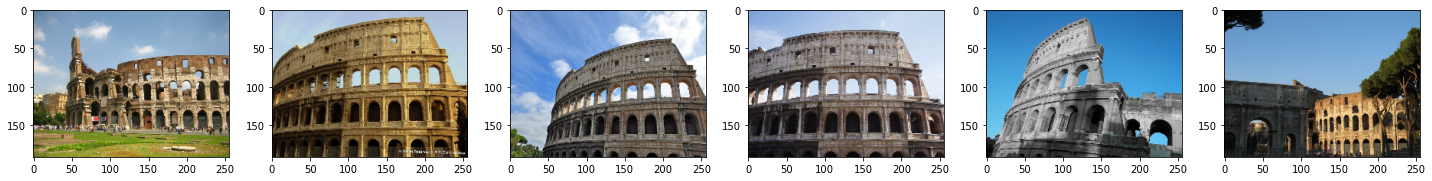

In [12]:
sample_size = 6
rand_idx = np.random.randint(len(imgs), size=sample_size)
print(rand_idx)
plt.figure(figsize=(20, 4))
for i in range(sample_size):
    plt.subplot(1, sample_size, i+1)
    plt.imshow(imgs[rand_idx[i]])
    plt.tight_layout()

# 2. Generate fake Data

In [13]:
from copy import deepcopy

import pandas as pd

In [14]:
imgs[0].shape

(192, 256, 3)

In [15]:
def create_blackbox_position(origin_size, idx):
    bbox_size = [64, 64]
    col = origin_size[1] // bbox_size[1]
    div_row, div_col = divmod(idx, col)
    start_y = bbox_size[0] * div_row
    end_y = bbox_size[0] + start_y
    start_x = bbox_size[1] * div_col
    end_x = bbox_size[1] + start_x
    return start_y, end_y, start_x, end_x


# def create_blackbox(origin_size, idx):
#     bbox_size = [64, 64]
#     col = origin_size[1] // bbox_size[1]
#     start_y = bbox_size[0] * (idx // col)
#     end_y = bbox_size[0] + start_y
#     start_x = bbox_size[1] * (idx % col)
#     end_x = bbox_size[1] + start_x
#     return start_y, end_y, start_x, end_x


In [16]:
def create_training_set(target_image, amount, df_columns):
    sample_dict = {}
    cps = []
    for i in range(amount):
        cp = deepcopy(target_image)
        start_y, end_y, start_x, end_x = create_blackbox_position(cp.shape[:2], i)
        cp[start_y:end_y, start_x:end_x] = 0
        cps += [cp]
    sample_dict[df_columns[0]] = cps
    sample_dict[df_columns[1]] = [target_image] * len(cps)
    df_sample = pd.DataFrame(sample_dict)
    return df_sample

In [17]:
df_columns = ["input", "target"]
df_train = pd.DataFrame(columns=df_columns)
for i in range(len(imgs)):
    df_sample = create_training_set(imgs[i], 12, df_columns)
    df_train = pd.concat([df_train, df_sample], axis=0, ignore_index=True)

del imgs

# 3. 데이터 전처리

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
def preprocessing_train_data(df_train):
    X = np.array(df_train["input"].to_list())
    y = np.array(df_train["target"].to_list())
    X = X.astype("float32") / 255.
    y = y.astype("float32") / 255.
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
    return X_train, X_val, y_train, y_val

In [20]:
x_train, x_test, y_train, y_test = preprocessing_train_data(df_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

del df_train

# 4. Train Autoencoder
- Encoder + Decoder

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


## Model 구축

In [22]:
class ConvAutoencoder(Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.autoenc_model, self.encoder, self.decoder = self.build_model()

    def build_model(self):
        input_img = layers.Input(shape=(192, 256, 3))
        x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(input_img)
        x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(x)
        encoded = layers.Conv2D(16, 3, strides=2, activation="relu", padding="same", name="encoded")(x)

        x = layers.Conv2DTranspose(16, 3, strides=2, activation="relu", padding="same")(encoded)
        x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2DTranspose(256, 3, strides=2, activation="relu", padding="same")(x)
        decoded = layers.Conv2D(3, 3, activation="sigmoid", padding="same", name="decoded")(x)
        autoencoder = tf.keras.Model(input_img, decoded)
        autoencoder.compile(optimizer="adam", loss=losses.MeanSquaredError(), metrics=["accuracy"])
        encoder = tf.keras.Model(input_img, encoded)
        decoder = tf.keras.Model(encoded, decoded)
        return autoencoder, encoder, decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        
conv_autoencoder = ConvAutoencoder()

In [23]:
# def set_get_callbacks(train_name):
#     lr = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=3, verbos=1, min_lr=1e-8)
#     cp = ModelCheckpoint(filepath="./result/model_checkpoint/"+f"{train_name}"+"-{epoch:03d}-{loss:4f}-{val_loss:4f}.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#     return [cp, lr]

In [ ]:
def set_get_callbacks(train_name):
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=3, verbos=1, min_lr=1e-8)
    cp = ModelCheckpoint(filepath="./result/model_checkpoint/"+f"{train_name}"+".hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    return [cp, lr]

In [24]:
train_name = "autoenc_test"
cbs = set_get_callbacks(train_name)

In [25]:
history = conv_autoencoder.autoenc_model.fit(x_train, y_train, epochs=100, shuffle=True, validation_data=(x_val, y_val), callbacks=cbs, batch_size=1)

Epoch 1/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.4588
Epoch 1: val_loss improved from inf to 0.02269, saving model to ./result/model_checkpoint\autoenc_test-001-0.034383-0.022694.hdf5
1263/1263 [==============================] - 30s 19ms/step - loss: 0.0344 - accuracy: 0.4588 - val_loss: 0.0227 - val_accuracy: 0.4653 - lr: 0.0010
Epoch 2/100
1262/1263 [============================>.] - ETA: 0s - loss: 0.0221 - accuracy: 0.5707
Epoch 2: val_loss improved from 0.02269 to 0.01840, saving model to ./result/model_checkpoint\autoenc_test-002-0.022137-0.018398.hdf5
1263/1263 [==============================] - 22s 18ms/step - loss: 0.0221 - accuracy: 0.5707 - val_loss: 0.0184 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 3/100
1263/1263 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.6313
Epoch 3: val_loss improved from 0.01840 to 0.01802, saving model to ./result/model_checkpoint\autoenc_test-003-0.018798-0.018016.hdf5
1263/1263

In [26]:
def save_train_result(history, train_name):
    df = pd.DataFrame({"epoch":history.epoch,
                        "loss":history.history["loss"],
                        "accuracy":history.history["accuracy"],
                        "val_loss":history.history["val_loss"],
                        "val_accuracy":history.history["val_accuracy"]})
    write_path = f"./result/{train_name}.csv"
    df.to_csv(write_path)

In [27]:
save_train_result(history, train_name)

In [28]:
def display_loss_acc_result(history, save_file_name=None):
    plt.figure(figsize=(8,4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"],"b-", label="training")
    plt.plot(history.history["val_loss"],"r:", label="validation")
    plt.title("model - loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("model - accuracy")
    plt.plot(history.history["accuracy"],"b-", label="training")
    plt.plot(history.history["val_accuracy"],"r:", label="validation")

    plt.legend()
    plt.tight_layout()
    if save_file_name is not None:
        plt.savefig(f"./result/{save_file_name}.png")
    plt.show()

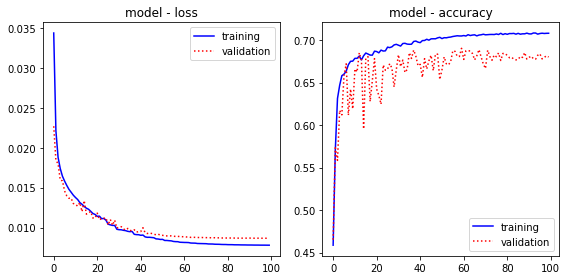

In [29]:

display_loss_acc_result(history, train_name)

# 5. Evaluate

In [30]:
del x_train
del y_train

In [31]:
x_val[rand_idx][tf.newaxis,...].shape

(1, 6, 192, 256, 3)

60


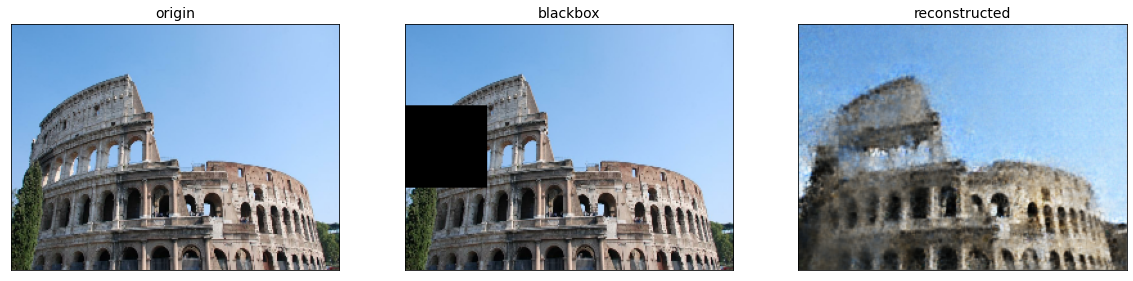

In [32]:
rand_idx = np.random.randint(len(x_val))
print(rand_idx)
encoded_img = conv_autoencoder.encoder(x_val[rand_idx][tf.newaxis,...]).numpy()
decoded_img = conv_autoencoder.decoder(encoded_img).numpy()

plt.figure(figsize=(20, 10))

# display origin
cx = plt.subplot(1, 3, 1)
plt.title("origin", fontsize=14)
plt.imshow(tf.squeeze(y_val[rand_idx]))
plt.gray()
cx.get_xaxis().set_visible(False)
cx.get_yaxis().set_visible(False)

# display blackbox
ax = plt.subplot(1, 3, 2)
plt.title("blackbox", fontsize=14)
plt.imshow(tf.squeeze(x_val[rand_idx]))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# display reconstruction
bx = plt.subplot(1, 3, 3)
plt.title("reconstructed", fontsize=14)
plt.imshow(tf.squeeze(decoded_img.squeeze()))
plt.gray()
bx.get_xaxis().set_visible(False)
bx.get_yaxis().set_visible(False)


In [33]:
loss, acc = conv_autoencoder.autoenc_model.evaluate(x_test, y_test, batch_size=1, verbose=1)
print(loss, acc)

156/156 [==============================] - 1s 9ms/step - loss: 0.0089 - accuracy: 0.6935
0.008859445340931416 0.6935132741928101


In [34]:
new_cnv_model = ConvAutoencoder()

cp_path = "./result/model_checkpoint/"
best_model_filename = os.listdir(cp_path)[-1]

best_model_file = os.path.join(cp_path,best_model_filename)

new_cnv_model.autoenc_model.load_weights(best_model_file)


In [35]:
new_cnv_model.autoenc_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 128, 256)      7168      
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 64, 128)       295040    
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 32, 64)        73792     
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 16, 32)        18464     
                                                                 
 encoded (Conv2D)            (None, 6, 8, 16)          4624      
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 12, 16, 16)       2320

In [36]:
new_cnv_model.encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 128, 256)      7168      
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 64, 128)       295040    
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 32, 64)        73792     
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 16, 32)        18464     
                                                                 
 encoded (Conv2D)            (None, 6, 8, 16)          4624      
                                                                 
Total params: 399,088
Trainable params: 399,088
Non-trainab

In [37]:
new_cnv_model.decoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6, 8, 16)]        0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 12, 16, 16)       2320      
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 24, 32, 32)       4640      
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 48, 64, 64)       18496     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 96, 128, 128)     73856     
 ranspose)                                                 

34


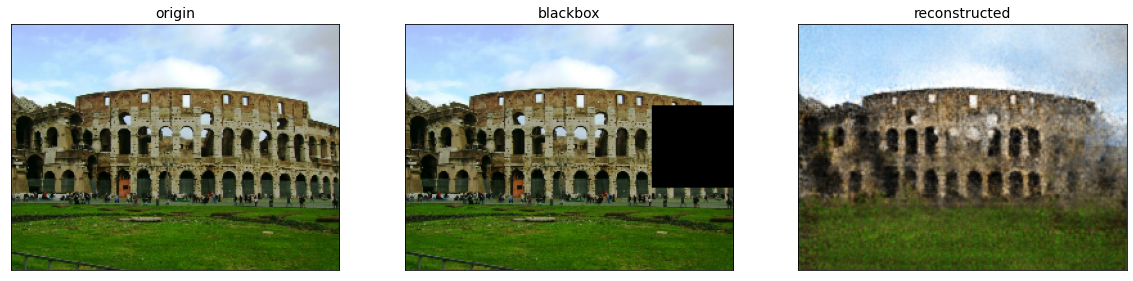

In [39]:
rand_idx = np.random.randint(len(x_val))
print(rand_idx)
encoded_img = new_cnv_model.encoder(x_val[rand_idx][tf.newaxis,...]).numpy()
decoded_img = new_cnv_model.decoder(encoded_img).numpy()

plt.figure(figsize=(20, 10))

# display origin
cx = plt.subplot(1, 3, 1)
plt.title("origin", fontsize=14)
plt.imshow(y_val[rand_idx])
plt.gray()
cx.get_xaxis().set_visible(False)
cx.get_yaxis().set_visible(False)

# display blackbox
ax = plt.subplot(1, 3, 2)
plt.title("blackbox", fontsize=14)
plt.imshow(tf.squeeze(x_val[rand_idx]))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# display reconstruction
bx = plt.subplot(1, 3, 3)
plt.title("reconstructed", fontsize=14)
plt.imshow(decoded_img.squeeze())
plt.gray()
bx.get_xaxis().set_visible(False)
bx.get_yaxis().set_visible(False)


123


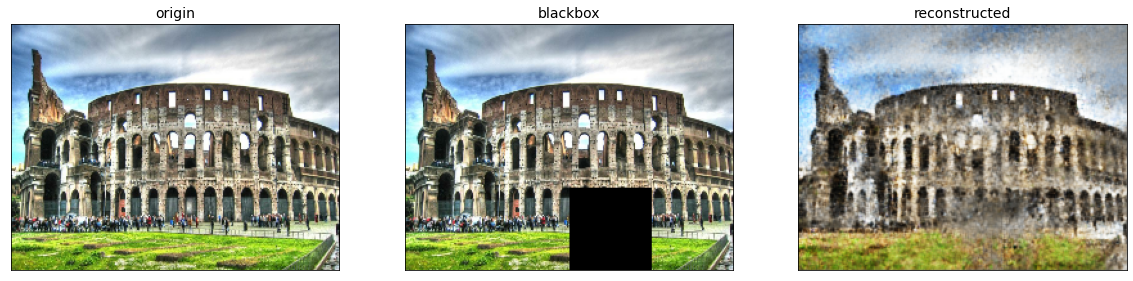

In [40]:
rand_idx = np.random.randint(len(x_test))
print(rand_idx)
encoded_img = new_cnv_model.encoder(x_test[rand_idx][tf.newaxis,...]).numpy()
decoded_img = new_cnv_model.decoder(encoded_img).numpy()

plt.figure(figsize=(20, 10))

# display origin
cx = plt.subplot(1, 3, 1)
plt.title("origin", fontsize=14)
plt.imshow(y_test[rand_idx])
plt.gray()
cx.get_xaxis().set_visible(False)
cx.get_yaxis().set_visible(False)

# display blackbox
ax = plt.subplot(1, 3, 2)
plt.title("blackbox", fontsize=14)
plt.imshow(tf.squeeze(x_test[rand_idx]))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# display reconstruction
bx = plt.subplot(1, 3, 3)
plt.title("reconstructed", fontsize=14)
plt.imshow(decoded_img.squeeze())
plt.gray()
bx.get_xaxis().set_visible(False)
bx.get_yaxis().set_visible(False)


In [41]:
def create_random_blackbox_img(image):
    h, w, _ = image.shape
    top = np.random.randint(0, h - 64)
    left = np.random.randint(0, w - 64)
    blackblox_img = deepcopy(image)
    blackblox_img[top:top+64, left:left+64, :] = 0
    return blackblox_img

In [42]:
def create_random_blackbox_img(image):
    h, w, _ = image.shape
    top = np.random.randint(0, h - 64)
    left = np.random.randint(0, w - 64)
    blackblox_img = deepcopy(image)
    blackblox_img[top:top+64, left:left+64, :] = 0
    return blackblox_img

In [43]:
def create_custom_blackbox_img(image, x, y, w, h):
    blackblox_img = deepcopy(image)
    blackblox_img[y:y+h, x:x+w, :] = 0
    return blackblox_img

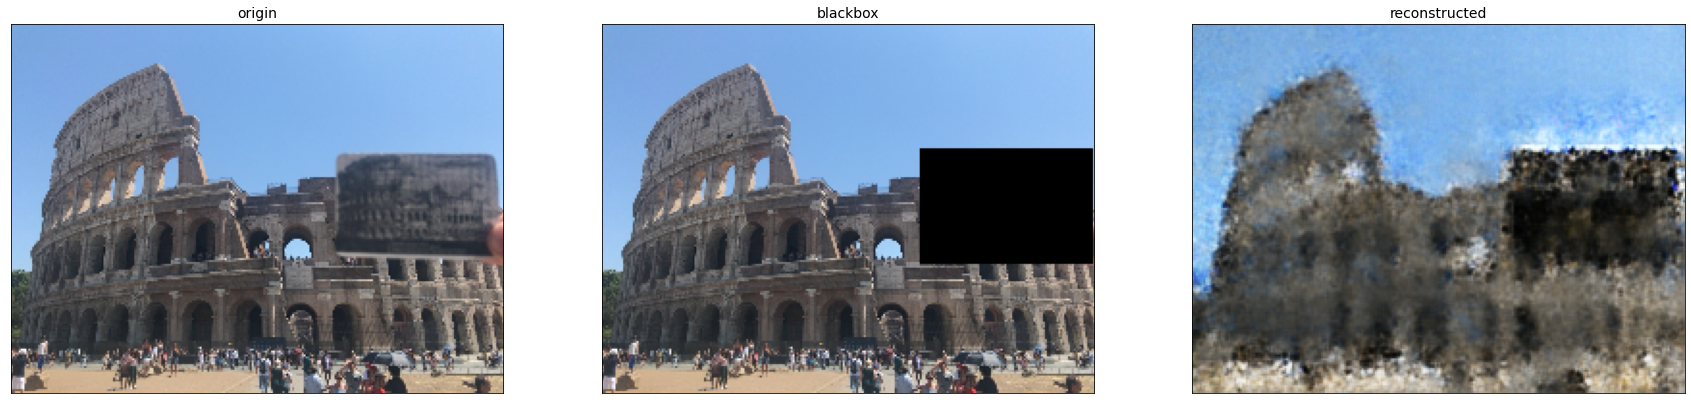

In [53]:
test_image = load_image("./data/autoenc_data/test/test2.JPG")
test_image = test_image / 255.
b_image = create_custom_blackbox_img(test_image, 165, 65, 90, 60)


decoded_img = new_cnv_model(b_image[tf.newaxis,...]).numpy()

plt.figure(figsize=(30, 10))

# display origin
cx = plt.subplot(1, 3, 1)
plt.title("origin", fontsize=14)
plt.imshow(test_image)
plt.gray()
cx.get_xaxis().set_visible(False)
cx.get_yaxis().set_visible(False)

# display blackbox
ax = plt.subplot(1, 3, 2)
plt.title("blackbox", fontsize=14)
plt.imshow(tf.squeeze(b_image))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# display reconstruction
bx = plt.subplot(1, 3, 3)
plt.title("reconstructed", fontsize=14)
plt.imshow(decoded_img.squeeze())
plt.gray()
bx.get_xaxis().set_visible(False)
bx.get_yaxis().set_visible(False)



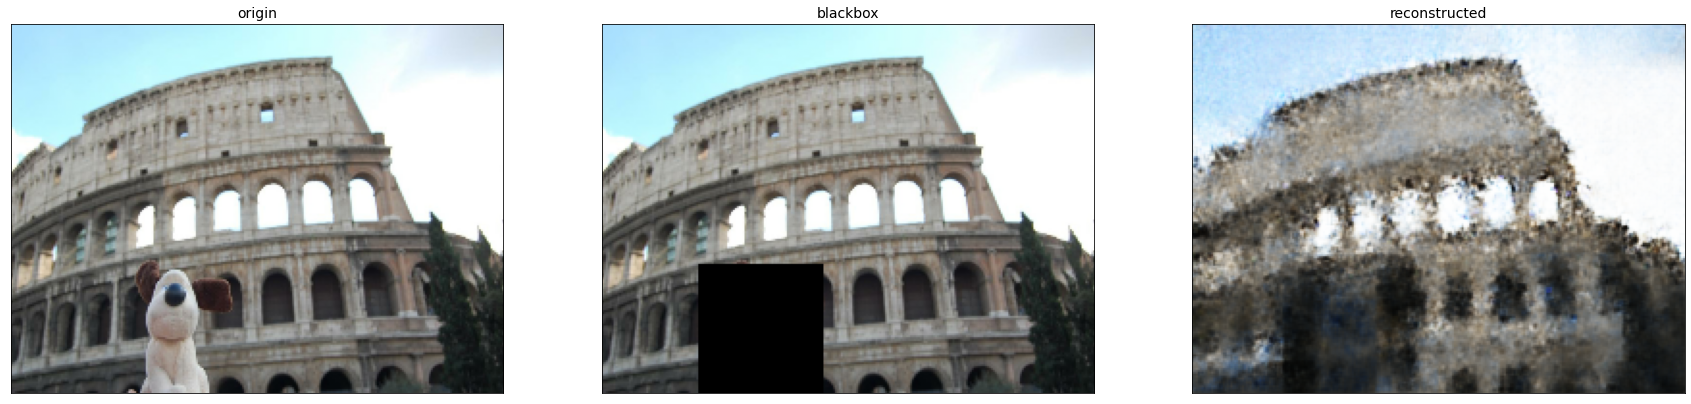

In [56]:
test_image = load_image("./data/autoenc_data/test/test3.jpg")
test_image = test_image / 255.
b_image = create_custom_blackbox_img(test_image, 50, 125, 65, 80)


decoded_img = new_cnv_model(b_image[tf.newaxis,...]).numpy()

plt.figure(figsize=(30, 10))

# display origin
cx = plt.subplot(1, 3, 1)
plt.title("origin", fontsize=14)
plt.imshow(test_image)
plt.gray()
cx.get_xaxis().set_visible(False)
cx.get_yaxis().set_visible(False)

# display blackbox
ax = plt.subplot(1, 3, 2)
plt.title("blackbox", fontsize=14)
plt.imshow(tf.squeeze(b_image))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# display reconstruction
bx = plt.subplot(1, 3, 3)
plt.title("reconstructed", fontsize=14)
plt.imshow(decoded_img.squeeze())
plt.gray()
bx.get_xaxis().set_visible(False)
bx.get_yaxis().set_visible(False)

